<a href="https://colab.research.google.com/github/QuantumQist/Deep-Learning-Toy-Problems/blob/main/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

We consider an example of variational autoencoder for the MNIST dataset. Our goals are
1. Train the autoencoder for latent representation of size 2, i.e., we should have to provide only two numbers to generate the output from the decoder.
2. Create a slider showing how the numbers are generated.

This notebook contains the following sections
1. Prepare the data to enter the PyTorch model.
2. Create the model class.
3. Create a training loop.
4. Train the model.
5. Evaluate the model by plotting random reconstructions.
6. Plot a matrix of images: plot the image vs. decoder input.
7. Create a slider to generate new data.

In [ ]:
import torch, torchvision
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE}")

cuda


## 1. Prepare data to enter the PyTorch model

We will import MNIST training and testing dataset.

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
test_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)

Plot two random samples from each dataset

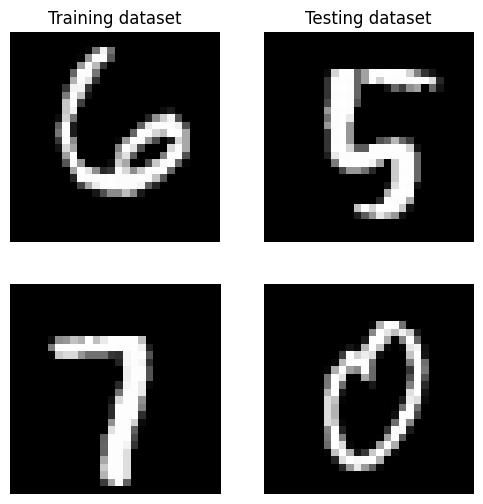

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6))
datasets = [train_dataset, test_dataset]
# Loop over columns
for i in range(2):
  # Get two samples
  RANDOM_IDXS = random.sample(range(len(datasets[i])), k=2)
  for j in range(2): # Loop over rows in column
    # Get the image
    img = datasets[i].__getitem__(RANDOM_IDXS[j])[0].squeeze().numpy()
    axs[j, i].imshow(img, cmap = "gray")
    axs[j, i].axis(False)
axs[0,0].set_title("Training dataset")
axs[0,1].set_title("Testing dataset");

In [ ]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# 2. Create a model class

The architecture is based on https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f


In [ ]:
class VAE_V2(nn.Module):
  """
  Class definind the variational autoencoder model

  Parameters:
    * hidden units: int
      Number of hidden units, decoder input
    * device: str:
      Device where the model and data will be stored.
  """
  def __init__(self, hidden_units:int, device = DEVICE):
    super().__init__()

    self.flatten_layer = nn.Flatten()

    # Define the encoder block
    self.encoder_block = nn.Sequential(
        nn.Linear(in_features = 784, out_features = 400),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features = 400, out_features = 200),
        nn.LeakyReLU(0.2),
    )
    # Define the layers with means and logvar vector outputs
    self.encoder_block_to_mean = nn.Linear(in_features = 200, out_features = hidden_units)
    self.encoder_block_to_logvar = nn.Linear(in_features = 200, out_features = hidden_units)

    # Define the decoder block
    self.decoder_block = nn.Sequential(
      nn.Linear(in_features = hidden_units, out_features = 200),
      nn.LeakyReLU(0.2),
      nn.Linear(in_features = 200, out_features = 400),
      nn.LeakyReLU(0.2),
      nn.Linear(in_features = 400, out_features = 784),
      nn.Sigmoid()
    )

    # Reshape layer (brings the decoder output vector ack to the original shape)
    self.reshape = nn.Unflatten(dim = -1, unflattened_size=(1,28,28))

  def encoder(self, x):
    """
    Defines the encoder piece of variational autoencoder.
    Returns a tuple with the vecors of means and standard deviations
    """
    x = self.flatten_layer(x)
    return self.encoder_block_to_mean(self.encoder_block(x)), self.encoder_block_to_logvar(self.encoder_block(x))

  def decoder(self, x):
    """
    Defines the decoder head.
    """
    return self.reshape( self.decoder_block(x) )

  def forward(self, x):
    # Get mean and std
    mean_vec, sigma_vec = self.encoder(x)
    # Reparametrization trick
    epsilon = torch.randn_like(sigma_vec, device = DEVICE)
    # Reparametrized decoder input
    z_reparametrized = mean_vec + epsilon*sigma_vec
    return self.decoder( z_reparametrized ), mean_vec, sigma_vec

In [ ]:
# Create an instance of the model
vae = VAE(hidden_units = 2).to(DEVICE)

### Dummy forward pass
# Get sample image
feature = train_dataset.__getitem__(42)[0].unsqueeze(dim=0).to(DEVICE)
print(f"Input shape: {feature.shape}")
# Forward pass
output = vae(feature)
print(f"Enocder output:\n- Mean vector shape: {output[1].shape},\n- Std vector shape: {output[2].shape}")
print(f"Decoder output shape: {output[0].shape}")

Input shape: torch.Size([1, 1, 28, 28])
Enocder output:
- Mean vector shape: torch.Size([1, 2]),
- Std vector shape: torch.Size([1, 2])
Decoder output shape: torch.Size([1, 1, 28, 28])


## 3. Create a training loop

Based on
* https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
* https://www.youtube.com/watch?v=VELQT1-hILo

The function from the link above was adjusted to account for the training of variational autoencoder.

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List

def trian_vae(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: torch.device,
    kl_coeff: float = 1) -> Dict[str, List]:
  """
  Trains a PyTorch variational autoencoder model.
  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: torch.nn.Module
      PyTorch model to be trained.
    train_dataloader: torch.utils.data.DataLoader
      DataLoader with training data
    test_dataloader: torch.utils.data.DataLoader
      DataLoader with testing data
    loss_fn: torch.nn.Module
      Loss function used to compare reconstruction to the input
    optimizer: torch.optim.Optimizer
      Optimizer used for training
    num_epochs: int
      Number of epochs to train the model for
    device: torch.device
      Device to train the model on
    kl_coeff: float, default = 1
      Coefficient multiplying the KL divergence loss term

  Returns: A dictionary of training and testing loss in the form
    {train_loss: [...],
      train_acc: [...]}
  """
  # Put model on target device
  model.to(device)

  # Setup the list to store evaluation
  train_loss_list = []
  test_loss_list = []

  # Loop over epochs
  for epoch in tqdm(range(num_epochs)):

    ### Training
    model.train()
    # Setup variable to store loss per batch
    train_loss = 0.
    # Loop over batches
    for batch, (X, __) in enumerate(train_dataloader):
      # Put data on target device
      X = X.to(device)

      # Forward pass
      reconstruction, mean_vec, sigma_vec = model(X)

      # Compute reconstruction loss
      reconstruction_loss = loss_fn(reconstruction, X)
      # Compute KL divergence loss term (https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a)
      kl_div = - torch.sum(1 + torch.log(sigma_vec.pow(2))- mean_vec.pow(2) - sigma_vec.pow(2))
      # Compute total loss
      loss = reconstruction_loss + kl_coeff * kl_div
      train_loss += loss.item()

      # Zero gradients
      optimizer.zero_grad()
      # Backpropagation
      loss.backward()
      # Step the optimizer
      optimizer.step()

    # Adjust loss to get loss per batch
    train_loss_list.append( train_loss / len(train_dataloader) )

    ### Testing
    model.eval()
    # Setup variable to store loss per batch
    test_loss = 0.
    # Loop over test date batches
    for batch, (X, __) in enumerate(test_dataloader):
      # Put data on target device
      X = X.to(device)

      # Forward pass
      with torch.inference_mode():
        reconstruction, mean_vec, sigma_vec = model(X)

      # Compute KL divergence loss term (https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a)
      kl_div = - torch.sum(1 + torch.log(sigma_vec.pow(2))- mean_vec.pow(2) - sigma_vec.pow(2))
      # Compute total loss
      loss = reconstruction_loss + kl_coeff * kl_div
      test_loss += loss.item()

    # Adjust loss to get loss per batch
    test_loss_list.append( test_loss / len(test_dataloader) )

    # Print what's happening
    print(f"Epoch {epoch+1} | Train loss: {train_loss_list[-1]} | Test loss: {test_loss_list[-1]}")

  return {"Train_loss": train_loss_list,
          "Test_loss": test_loss_list}

## 4. Train the model

We will train two models
1. With KL term: `vae_kl`.
2. Without KL term (normal autoencoder): `vae_0`.

### 4.1. Training with KL term.

In [ ]:
EPOCHS = 10

# Create an instance of the model
vae_kl = VAE_V2(hidden_units = 2).to(DEVICE)

loss_fn = nn.BCELoss(reduction = "sum")
optimizer = torch.optim.Adam(params = vae_kl.parameters(), lr = 3e-4)

results = trian_vae(
    model = vae_kl,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    num_epochs = EPOCHS,
    device = DEVICE,
    kl_coeff = 1
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Train loss: 12639.950520659815 | Test loss: 5643.919862783639
Epoch 2 | Train loss: 11003.685379256063 | Test loss: 5513.611073099124
Epoch 3 | Train loss: 10779.125183235608 | Test loss: 5710.319575413017
Epoch 4 | Train loss: 10622.77978515625 | Test loss: 5168.6102831409235
Epoch 5 | Train loss: 10476.530952762692 | Test loss: 4946.713497088973
Epoch 6 | Train loss: 10363.071548819797 | Test loss: 5198.020159484475
Epoch 7 | Train loss: 10271.793650677972 | Test loss: 5503.321898636545
Epoch 8 | Train loss: 10196.841290374301 | Test loss: 5266.250749527269
Epoch 9 | Train loss: 10127.409476404251 | Test loss: 5085.524952104896
Epoch 10 | Train loss: 10062.365567010094 | Test loss: 5467.788151249005


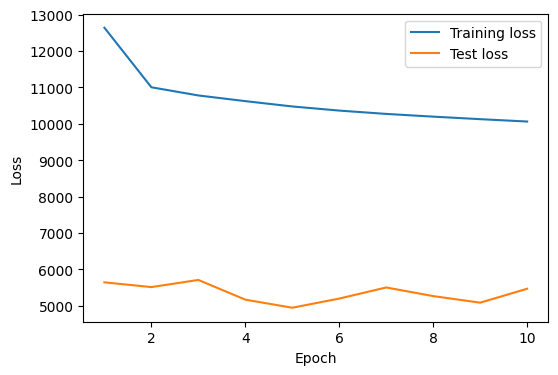

In [ ]:
# Plot loss curves
plt.figure(figsize = (6,4))
# X axis data
epochs = range(1, len(results["Train_loss"]) + 1)
plt.plot(epochs, results["Train_loss"], label = "Training loss")
plt.plot(epochs, results["Test_loss"], label = "Test loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

### 4.2. Training wiout KL term

In [ ]:
EPOCHS = 10

# Create an instance of the model
vae_0 = VAE_V2(hidden_units = 2).to(DEVICE)

loss_fn = nn.BCELoss(reduction = "sum")
optimizer = torch.optim.Adam(params = vae_0.parameters(), lr = 3e-4)

results_0 = trian_vae(
    model = vae_0,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    num_epochs = EPOCHS,
    device = DEVICE,
    kl_coeff = 0
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Train loss: 12064.768778005897 | Test loss: 5133.82177734375
Epoch 2 | Train loss: 10424.983218325227 | Test loss: 5211.7421875
Epoch 3 | Train loss: 9995.380641782716 | Test loss: 4891.8525390625
Epoch 4 | Train loss: 9783.256452808502 | Test loss: 4862.58203125
Epoch 5 | Train loss: 9627.626708984375 | Test loss: 5033.869140625
Epoch 6 | Train loss: 9508.076081298308 | Test loss: 4254.447265625
Epoch 7 | Train loss: 9409.750562200159 | Test loss: 5021.8388671875
Epoch 8 | Train loss: 9329.977525007496 | Test loss: 4615.2666015625
Epoch 9 | Train loss: 9255.913240542544 | Test loss: 4445.3623046875
Epoch 10 | Train loss: 9192.428026927306 | Test loss: 4432.5947265625


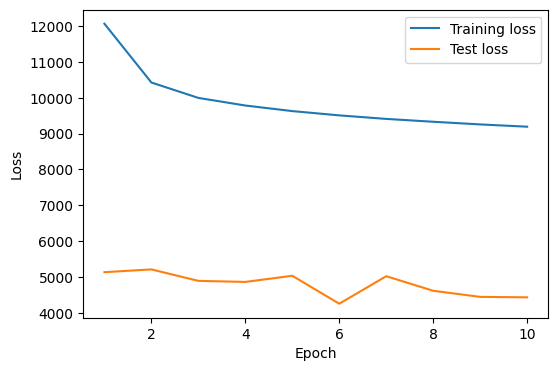

In [ ]:
# Plot loss curves
plt.figure(figsize = (6,4))
# X axis data
epochs = range(1, len(results["Train_loss"]) + 1)
plt.plot(epochs, results_0["Train_loss"], label = "Training loss")
plt.plot(epochs, results_0["Test_loss"], label = "Test loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

## 5. Evaluate the model

We will
* Plot random reconstructions from the model
* Plot latent representation of the model

# 5.1. Plot random reconstruction

In [ ]:
def plot_random_reconstructions(
    model: torch.nn.Module,
    dataset: torch.utils.data.Dataset,
    device: torch.device,
    title: str):
  """
  Plot 3 random model reconstructions from the provided dataset
  """
  # Get model ready for inference
  model.eval()

  # Get 3 random indexes
  random_idx_list = random.sample(range(len(dataset)), k = 3)

  # Create the plot
  fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (6, 9))
  for row, idx in enumerate(random_idx_list):
    # Get sample to be reconstructed and add batch dimension
    sample = dataset.__getitem__(idx)[0].unsqueeze(dim=0).to(device)

    # Get original image and plot it
    original_img = sample.squeeze().cpu().numpy()
    axs[row, 0].imshow(original_img, cmap = "gray")

    # Get model reconstruction
    with torch.inference_mode():
      reconstruction = vae(sample)[0].squeeze().cpu().numpy()
    axs[row, 1].imshow(reconstruction, cmap = "gray")
    fig.suptitle(title)



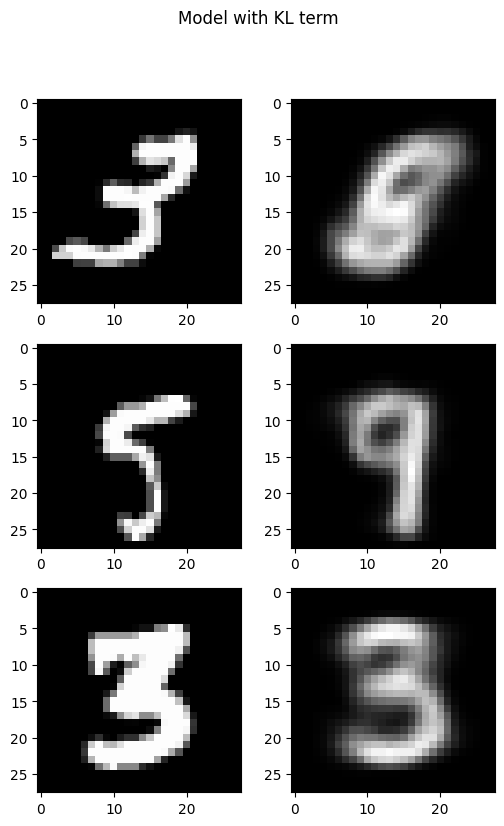

In [ ]:
plot_random_reconstructions(
    model = vae_kl,
    dataset = test_dataset,
    device = DEVICE,
    title = "Model with KL term"
)

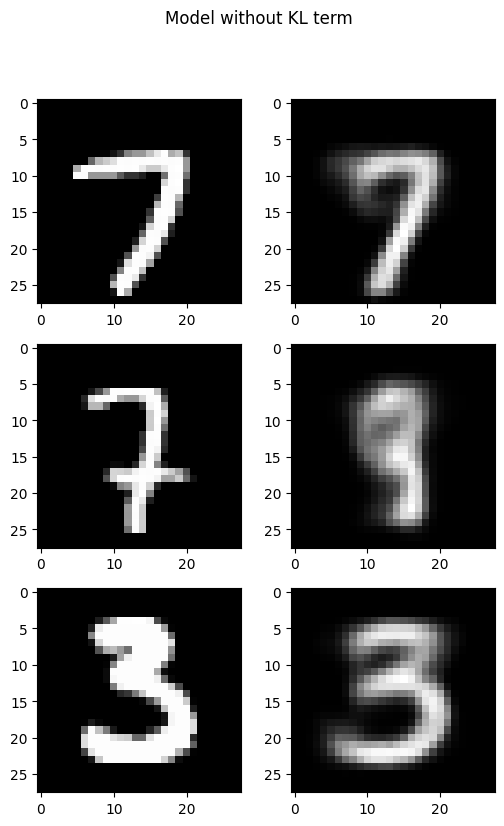

In [ ]:
plot_random_reconstructions(
    model = vae_0,
    dataset = test_dataset,
    device = DEVICE,
    title = "Model without KL term"
)

### 5.2. Plot the reconstruction vs decoder input.

In [ ]:
def create_encoder_output_df(model:torch.nn.Module,
                             dataset: torch.utils.data.Dataset,
                             device: torch.device):
  """
  Creates a pd.Dataframe of encoder outputs.
  """
  # Setup lists to store encoder output means and labels
  x0_list = []
  x1_list = []
  label_list = []
  # Prepare model for evaluation
  model = model.to(device)
  model.eval()

  # Loop over test dataset
  for idx in tqdm(range(len(dataset))):
    sample = dataset.__getitem__(idx)[0].unsqueeze(dim=0).to(device)

    # Get encoder outputs (means)
    with torch.inference_mode():
      mean_vec = model(sample)[1].squeeze()
    x0_list.append(mean_vec[0].item())
    x1_list.append(mean_vec[1].item())

    # Get label
    label = dataset.__getitem__(idx)[1]
    label_list.append(label)

  # Create a pd.DataFrame
  encoder_output_df = pd.DataFrame(
      data = {"x0": x0_list, "x1": x1_list, "label": label_list}
  )

  return encoder_output_df

In [ ]:
vae_kl_df = create_encoder_output_df(
    model = vae_kl,
    dataset = test_dataset,
    device = DEVICE
)
vae_0_df = create_encoder_output_df(
    model = vae_0,
    dataset = test_dataset,
    device = DEVICE
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

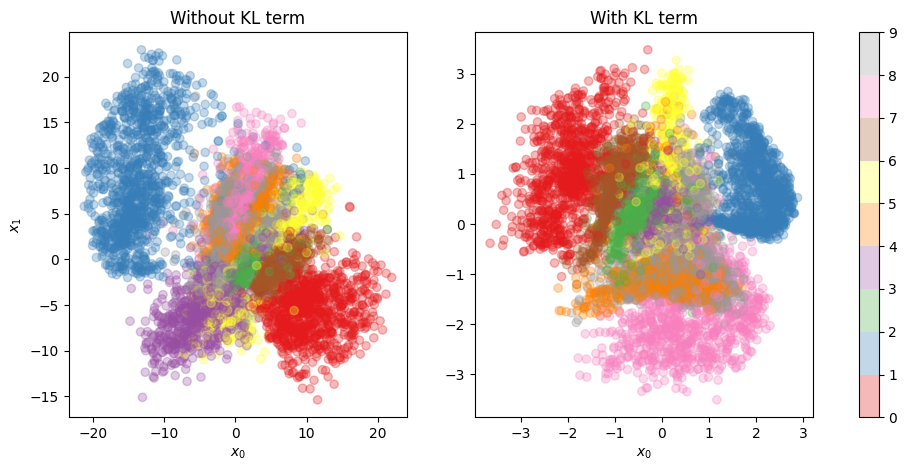

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ALPHA = 0.3
CMAP = "Set1"
plot0 = axs[0].scatter(
    vae_0_df["x0"], vae_0_df["x1"],
    c = vae_0_df["label"], alpha = ALPHA, cmap = CMAP)
axs[0].set_title("Without KL term")
axs[0].set_xlabel(r"$x_0$")
axs[0].set_ylabel(r"$x_1$")
plot1 = axs[1].scatter(
    vae_kl_df["x0"], vae_kl_df["x1"],
    c = vae_kl_df["label"], alpha = ALPHA, cmap = CMAP)
axs[1].set_title("With KL term")
axs[1].set_xlabel(r"$x_0$")
plt.colorbar(plot0, ax=axs.ravel().tolist())

## 6. Plot the matrix of images: decoder input vs output.

Below function taken from https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
with modifications to adjust for the code in this notebook

In [ ]:
def plot_latent_space(model, x_range, y_range, title,
                      n=25, digit_size=28, figsize=15,
                      device = DEVICE):
    # Prepare model for inference
    model.eval()
    model = model.to(DEVICE)

    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(x_range[0], x_range[1], n)
    grid_y = np.linspace(y_range[0], y_range[1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            with torch.inference_mode():
              z_sample = torch.tensor([xi, yi], dtype=torch.float).unsqueeze(dim=0).to(device)
              x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].squeeze().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title(title)
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel(r"$x_0$")
    plt.ylabel(r"$x_1$")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

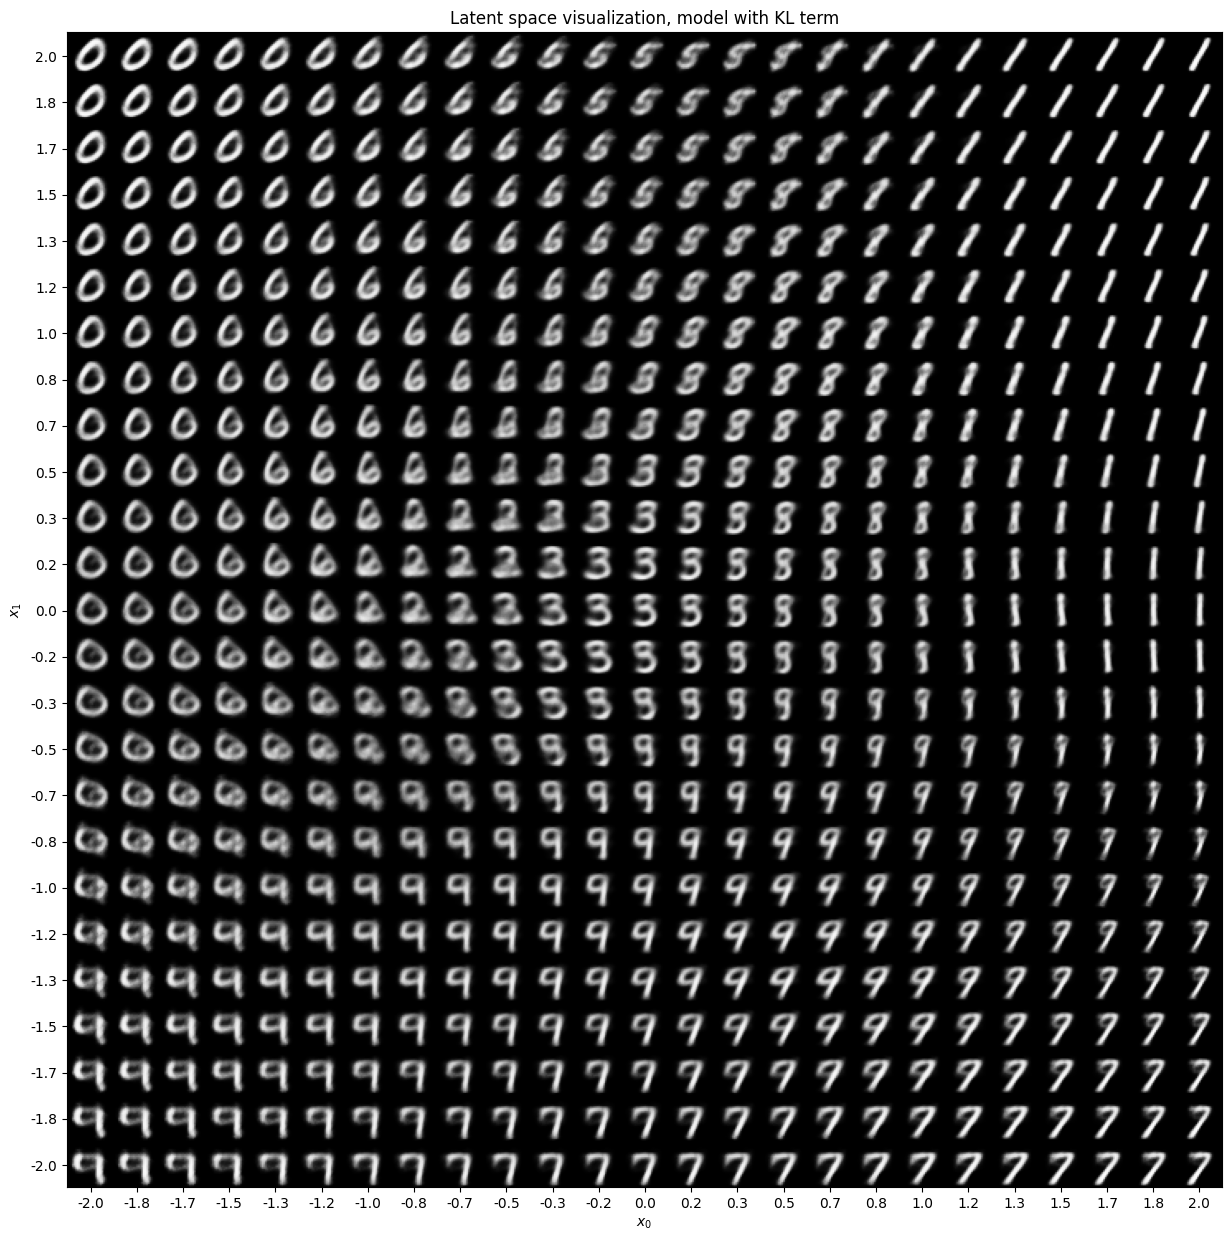

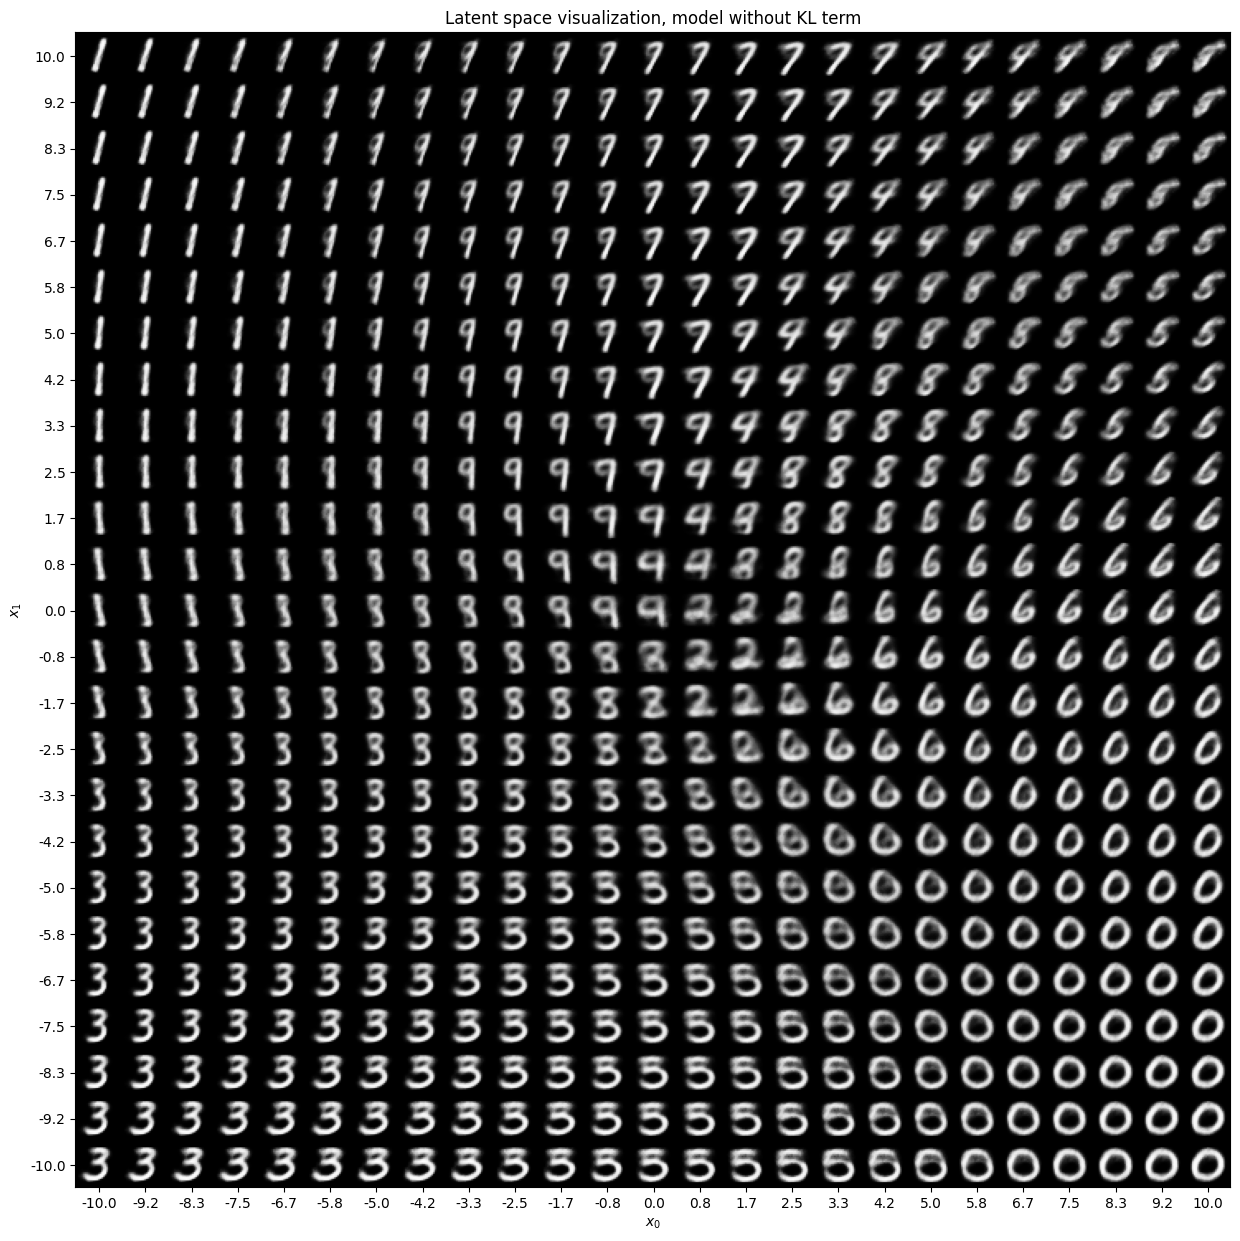

In [ ]:
plot_latent_space(model = vae_kl,
                  x_range = (-2, 2),
                  y_range = (-2, 2),
                  title = "Latent space visualization, model with KL term")
plot_latent_space(model = vae_0,
                  x_range = (-10, 10),
                  y_range = (-10, 10),
                  title = "Latent space visualization, model without KL term")

## 7. Create a slider allowing to generate an image.

In [116]:
def plot_image_from_decoder_input(
    x0: float, x1: float):
  """
  Takes in model with KL terms, plots encoder output based on the input sample
  """
  vae_kl.eval()
  # Prepare sample
  sample = torch.tensor([x0,x1], dtype = torch.float).unsqueeze(dim=0).to(DEVICE)

  # Make inference
  with torch.inference_mode():
    img = vae_kl.decoder(sample).squeeze().cpu().numpy()

  plt.figure(figsize=(12,12))
  plt.axis(False)
  plt.imshow(img, cmap = "gray")
  plt.show()

In [120]:
import ipywidgets
ipywidgets.interact(plot_image_from_decoder_input,
                   x0 = (min(vae_kl_df["x0"])/2, max(vae_kl_df["x0"])/2, 0.01),
                   x1 = (min(vae_kl_df["x1"])/2, max(vae_kl_df["x1"])/2,0.01));

interactive(children=(FloatSlider(value=-0.19478058338165272, description='x0', max=1.4409611225128174, min=-1…